# Selection of Study Region

This notebook is used to define the study region for the project.

The study region was selected based on the following criteria:
1. Most of the area in the State of New York
2. HUC-4 subregion (4 digits for digits Hydrologic Unit Code). A detailed explanation of Hydrologic Unit Codes is [available here](https://nas.er.usgs.gov/hucs.aspx).
3. Should include at least one of the counties: Ulster, Orange, Delaware, Sullivan, Greene

In [87]:
# Import packages
import geopandas as gpd
from shapely.geometry import Polygon
from pathlib import Path
from plotnine import *
import pandas as pd
import json
import warnings
from IPython.display import display, Markdown
import os

# Supress warnings
warnings.filterwarnings("ignore")

In [88]:
# File paths
project_base_path = Path.cwd().parent.parent
shapefiles_base_path = project_base_path / 'data' / 'raw' / 'geo' / 'shp'
us_county_path = shapefiles_base_path / 'us_county' / 'tl_2024_us_county.shp'
us_state_path = shapefiles_base_path / 'us_state' / 'tl_2024_us_state.shp'

In [89]:
# Load style configuration for maps
map_styles_path = project_base_path / 'config' / 'map_styles.json'
with open(map_styles_path, 'r') as f:
    map_style = json.load(f).get('map_styles',[])

In [90]:
# Load files
us_state = gpd.read_file(us_state_path)
us_county = gpd.read_file(us_county_path)

# Check CRS
if us_state.crs != us_county.crs:
    print('The CRS differs from each other. Converting CRS')
    us_county = us_county.to_crs(us_state.crs)
else:
    print('Both files are in the same CRS')


Both files are in the same CRS


## 1. Selecting the State of New York

Because the Watershed Boundary may go beyond the state of NY limits it is necessary to add to the boundary box the neighboring states.

In [11]:
# Selecting NY and neighbouring states
states_to_keep = ['New York', 'Pennsylvania', 'Connecticut', 'Massachusetts', 'Vermont']
us_eastern = us_state[us_state['NAME'].isin(states_to_keep)]
print(f'A total of {us_eastern.shape[0]} states were loaded.')

A total of 5 states were loaded.


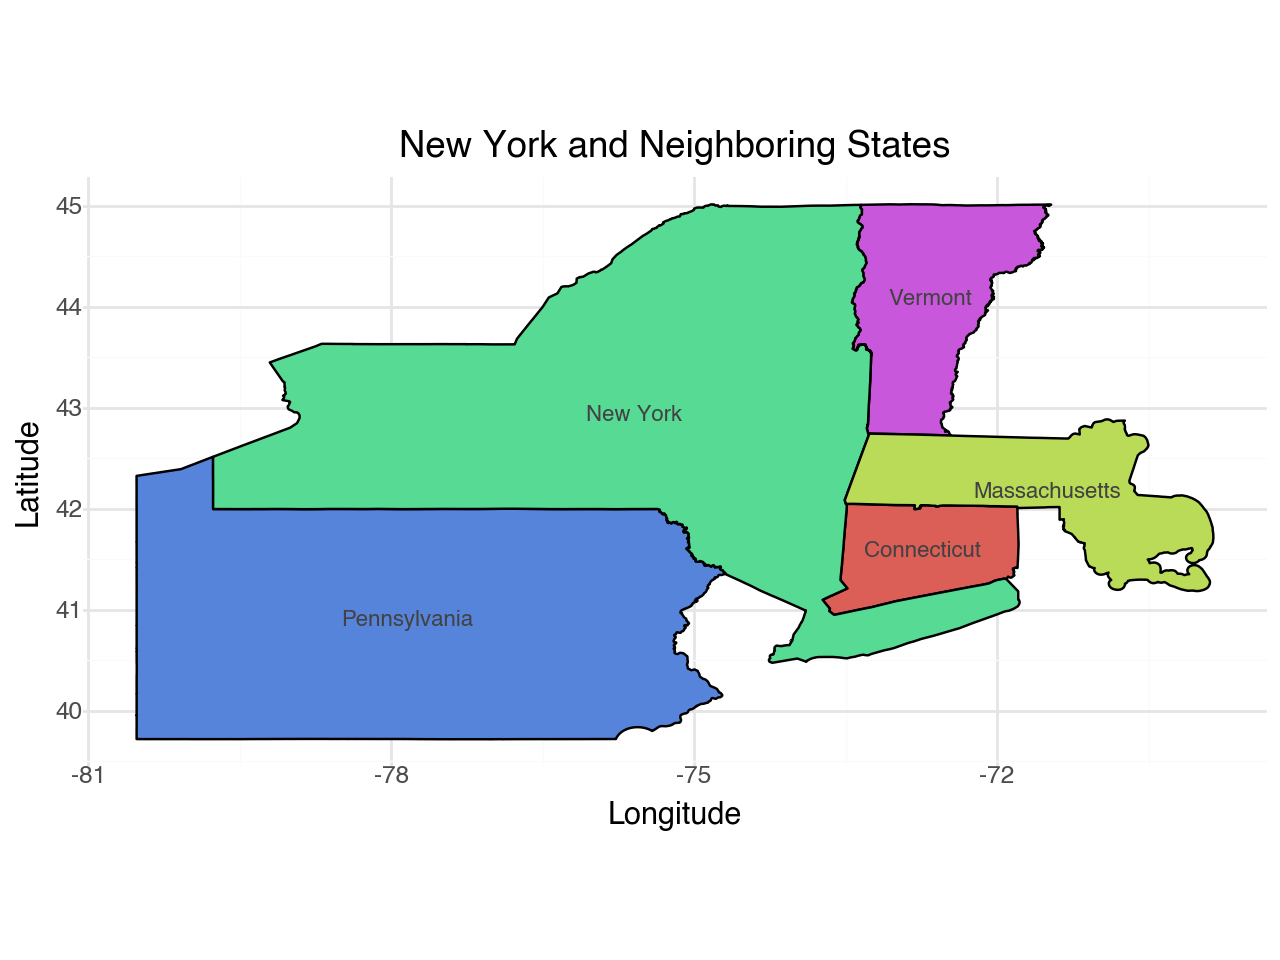

In [91]:
# Define the centroid of each polygon
us_eastern["lon"] = us_eastern.geometry.centroid.x
us_eastern["lat"] = us_eastern.geometry.centroid.y

# Map of the selected states
us_eastern_map = (
    ggplot(us_eastern)
    + geom_map(
        mapping=aes(fill="NAME", geometry="geometry"),
        data=us_eastern,
        color = 'black',
        inherit_aes=False
    )
    + geom_text(
        mapping=aes(x="lon", y="lat", label="NAME"),
        size=map_style.get('text').get('size'),
        color = map_style.get('text').get('color')
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="New York and Neighboring States", x="Longitude", y="Latitude")
)

us_eastern_map.show()

### 1.1 Boundary Box

In [13]:
# Boundary box
minx, miny, maxx, maxy = us_eastern.unary_union.bounds

bottom_left = (minx, miny)
bottom_right = (maxx, miny)
top_right = (maxx, maxy)
top_left = (minx, maxy)

bbox = dict(
    bottom_left=bottom_left,
    bottom_right=bottom_right,
    top_right=top_right,
    top_left=top_left,
    CRS=us_eastern.crs.to_string()
)

# Print as markdown
markdown_output = '  \n'.join([f"**{key}:** {value}" for key, value in bbox.items()])
display(Markdown('#### Boundary Box for the State of New York and Neighboring States:\n' + markdown_output))


#### Boundary Box for the State of New York and Neighboring States:
**bottom_left:** (-80.519851, 39.719799)  
**bottom_right:** (-69.858861, 39.719799)  
**top_right:** (-69.858861, 45.016658)  
**top_left:** (-80.519851, 45.016658)  
**CRS:** EPSG:4269

In [14]:
# Save boundary box locally as JSON file
ny_neighboring_bbox_json_path = project_base_path / 'data' / 'raw' /'geo' /'json' / 'ny_neighboring_bbox.json'

if not os.path.exists(ny_neighboring_bbox_json_path):
    try:
        # Export in JSON format
        with open(ny_neighboring_bbox_json_path, 'w') as f:
            json.dump(bbox, f, indent=4)
        display(Markdown('##### File with boundary box successfully saved locally as JSON.'))
    except Exception as err:
        print(f'Failed to save boundary box as JSON file: {err}')
else:
    print('Boundary box JSON file already exists. Skipping saving process.')

Boundary box JSON file already exists. Skipping saving process.


## 2. Selection of main Basin

In [92]:
# Before running the code of this cell, make sure to dowload the shapefiles from the /notebooks/data download.ipynb
WB_01_HU2_U2_path = shapefiles_base_path / 'WBD_01_HU2_Shape' / 'Shape' / 'WBDHU2.shp'
WB_02_HU2_U2_path = shapefiles_base_path / 'WBD_02_HU2_Shape' / 'Shape' / 'WBDHU2.shp'
WB_04_HU2_U2_path = shapefiles_base_path / 'WBD_04_HU2_Shape' / 'Shape' / 'WBDHU2.shp'
WB_05_HU2_U2_path = shapefiles_base_path / 'WBD_05_HU2_Shape' / 'Shape' / 'WBDHU2.shp'

# Load Watershed Boundaries
WB_01_HU2_U2 = gpd.read_file(WB_01_HU2_U2_path)
WB_02_HU2_U2 = gpd.read_file(WB_02_HU2_U2_path)
WB_04_HU2_U2 = gpd.read_file(WB_04_HU2_U2_path)
WB_05_HU2_U2 = gpd.read_file(WB_05_HU2_U2_path)

if not (WB_01_HU2_U2.crs == WB_02_HU2_U2.crs == WB_04_HU2_U2.crs == WB_05_HU2_U2.crs == us_state.crs):
    display(Markdown('One or more files are not in the same CRS as us_state. Changing CRS must be performed before continuing.'))
else:
    print('All shapefiles are in the same CRS.')

All shapefiles are in the same CRS.


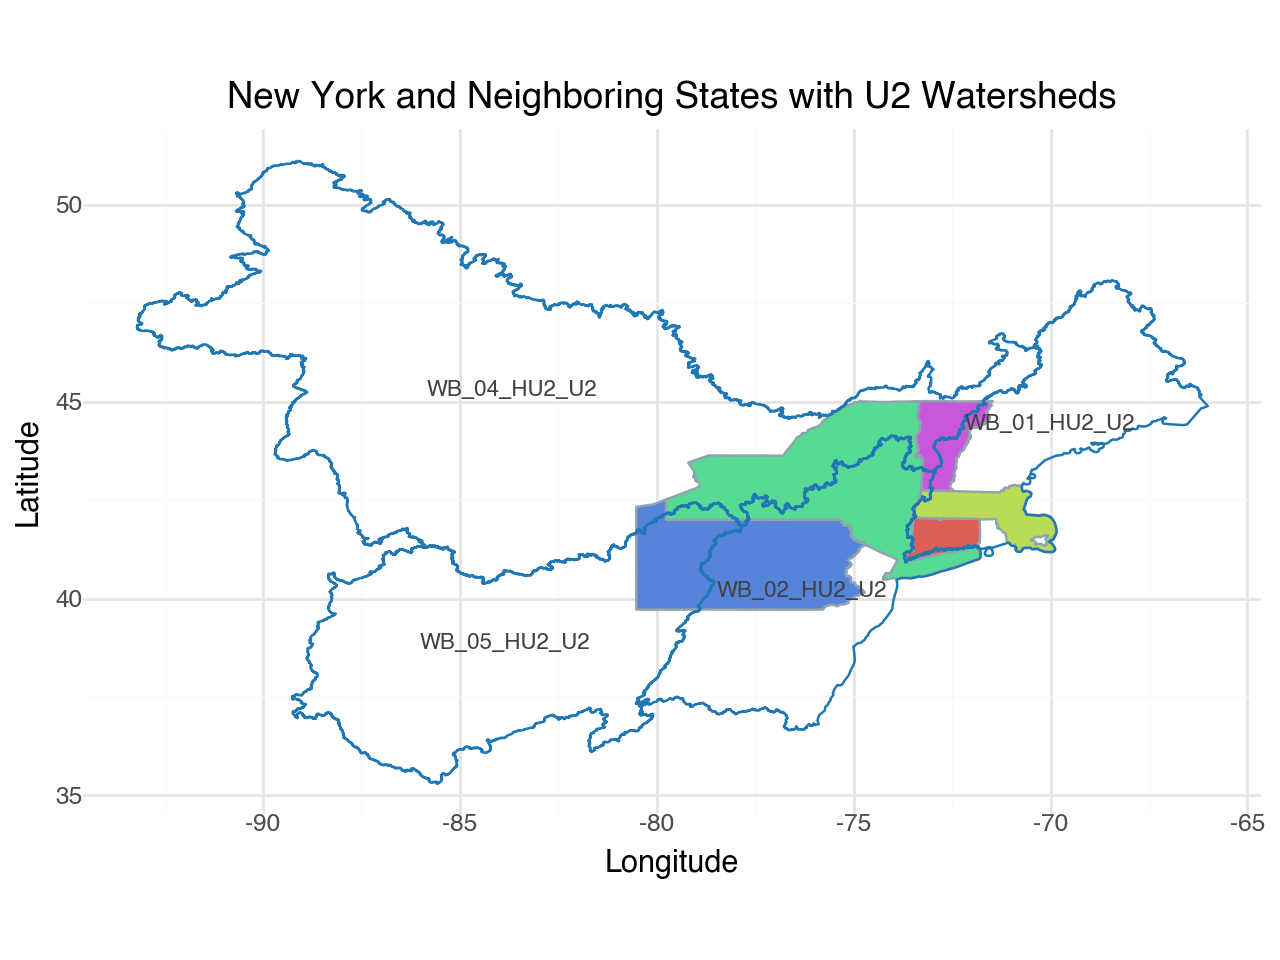

In [93]:
# Dictionary mapping object names to the objects
WB_objects = {
    "WB_01_HU2_U2": WB_01_HU2_U2,
    "WB_02_HU2_U2": WB_02_HU2_U2,
    "WB_04_HU2_U2": WB_04_HU2_U2,
    "WB_05_HU2_U2": WB_05_HU2_U2
}

# Create the DataFrame to show shapefile name on map
WB_HU2_DESC = pd.DataFrame({
    'lon': [float(source.geometry.centroid.x.iloc[0]) for source in WB_objects.values()],
    'lat': [float(source.geometry.centroid.y.iloc[0]) for source in WB_objects.values()],
    'desc': [name for name in WB_objects.keys()]
})

# Map styles
wsb_style = map_style.get('watershed_boundary')

# Map
basin_map = (
    ggplot()
    + geom_map(
        data=us_eastern,
        mapping=aes(fill="NAME", geometry="geometry"),
        inherit_aes=False,
        color = map_style.get('us_states').get('color')
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="New York and Neighboring States with U2 Watersheds", x="Longitude", y="Latitude")
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_01_HU2_U2,
        inherit_aes=False,
        color=wsb_style.get('color'),
        fill=None,
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_02_HU2_U2,
        inherit_aes=False,
        color=wsb_style.get('color'),
        fill=None,
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_04_HU2_U2,
        inherit_aes=False,
        color=wsb_style.get('color'),
        fill=None,
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_05_HU2_U2,
        inherit_aes=False,
        color=wsb_style.get('color'),
        fill=None,
    )
    + geom_text(
        mapping=aes(x='lon', y='lat', label='desc'),
        data=WB_HU2_DESC,
        inherit_aes=False,
        size=8,
        color=map_style.get('text').get('color')
    )
)
basin_map.show()


From the map above, it seems `WB_02_HU2_U2` covers the area of interest. Let's now objectivelly verify if the counties are indeed within the area of interest. If it does, we will select a subsin from the main WB_02_HU2 U2 basin.

## 3. Counties

It Should include at least one of the counties: Ulster, Orange, Delaware, Sullivan, Greene".

In [94]:
# Filter counties of interest
ny_state_fp = us_state[us_state['NAME'] == 'New York']['STATEFP'].iloc[0]
ny_counties = us_county[us_county['STATEFP'] == ny_state_fp]

counties_of_interest = ['Ulster', 'Orange', 'Delaware', 'Sullivan', 'Greene']

intersecting_counties_geom = gpd.clip(gdf=ny_counties, mask=WB_02_HU2_U2)
intersecting_counties_of_interest = [county for county in counties_of_interest if county in list(intersecting_counties_geom['NAME'])]

if intersecting_counties_of_interest:
    display(Markdown(f'##### The following counties of interest intersect with the watershed, and therefore the selected basin fits the chosen criteria: **{", ".join(intersecting_counties_of_interest)}.**\n'))
    display(Markdown(f'  A total of **{intersecting_counties_geom.shape[0]} counties** intersect with the Watershed Boundary.'))
else:
    print('No county of interest intersects with the Watershed Boundary')
    print('Counties of interest: ',counties_of_interest,'.')


##### The following counties of interest intersect with the watershed, and therefore the selected basin fits the chosen criteria: **Ulster, Orange, Delaware, Sullivan, Greene.**


  A total of **46 counties** intersect with the Watershed Boundary.

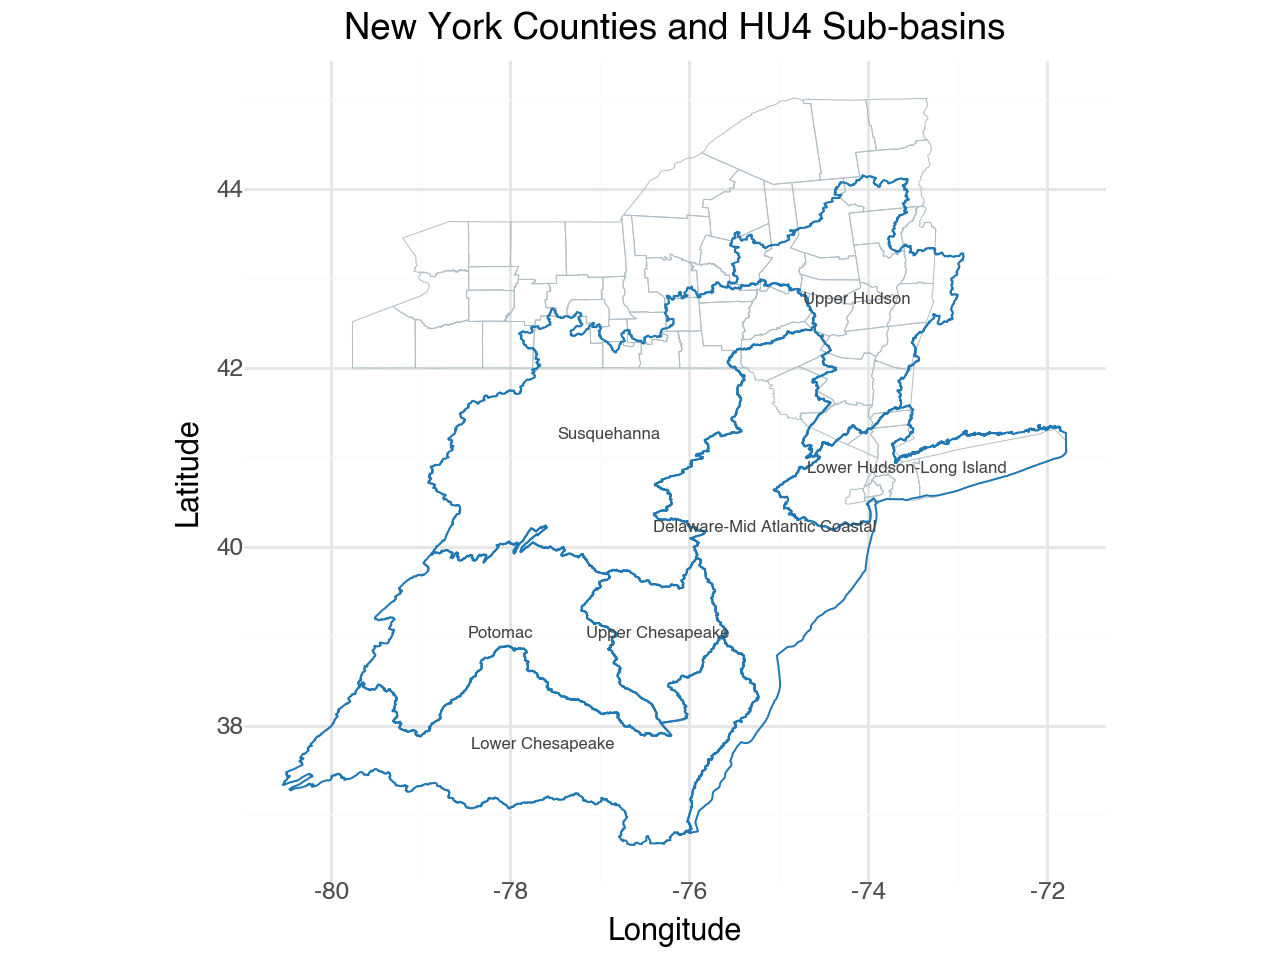

In [95]:
# Load the data
WB_02_HU2_U4_path = shapefiles_base_path / 'WBD_02_HU2_Shape' / 'Shape' / 'WBDHU4.shp'
WB_02_HU2_U4 = gpd.read_file(WB_02_HU2_U4_path)

# Define the centroid of each polygon
WB_02_HU2_U4["lon"] = WB_02_HU2_U4.geometry.centroid.x
WB_02_HU2_U4["lat"] = WB_02_HU2_U4.geometry.centroid.y

u4_sub_basin_map = (
    ggplot()
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=ny_counties,
        inherit_aes=False,
        fill=None,
        color=map_style.get('us_counties').get('color'),
        size = 0.2,
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="New York Counties and HU4 Sub-basins", x="Longitude", y="Latitude")
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_02_HU2_U4,
        inherit_aes=False,
        color=wsb_style.get('color'),
        fill=None,
        size = 0.4
    )
    + geom_text(
        mapping=aes(x='lon', y='lat', label='name'),
        data=WB_02_HU2_U4,
        inherit_aes=False,
        size=6,
        fontweight='bold',
        color= map_style.get('text').get('color')
    )
)
u4_sub_basin_map.show()


In [96]:
# Check if one or more counties 
upper_hudson_basin = WB_02_HU2_U4[WB_02_HU2_U4['name'] == 'Upper Hudson']

intersecting_counties_uhb_geom = gpd.clip(gdf=us_county, mask=upper_hudson_basin)
intersecting_counties_of_interest_uhb = [county for county in counties_of_interest if county in list(intersecting_counties_uhb_geom['NAME'])]

if intersecting_counties_of_interest_uhb:
    display(Markdown(f'  \nThe following counties of interest intersect with the watershed: **{", ".join(intersecting_counties_of_interest_uhb)}**\n  '))
    display(Markdown(f'  A total of **{intersecting_counties_geom.shape[0]} counties** intersect with the Watershed Boundary.'))
else:
    print('No county of interest intersects with the Watershed Boundary')

  
The following counties of interest intersect with the watershed: **Ulster, Orange, Delaware, Sullivan, Greene**
  

  A total of **46 counties** intersect with the Watershed Boundary.

The  **Upper Hudson** river subbasin fits all of the three criteria for the selecting the study region.

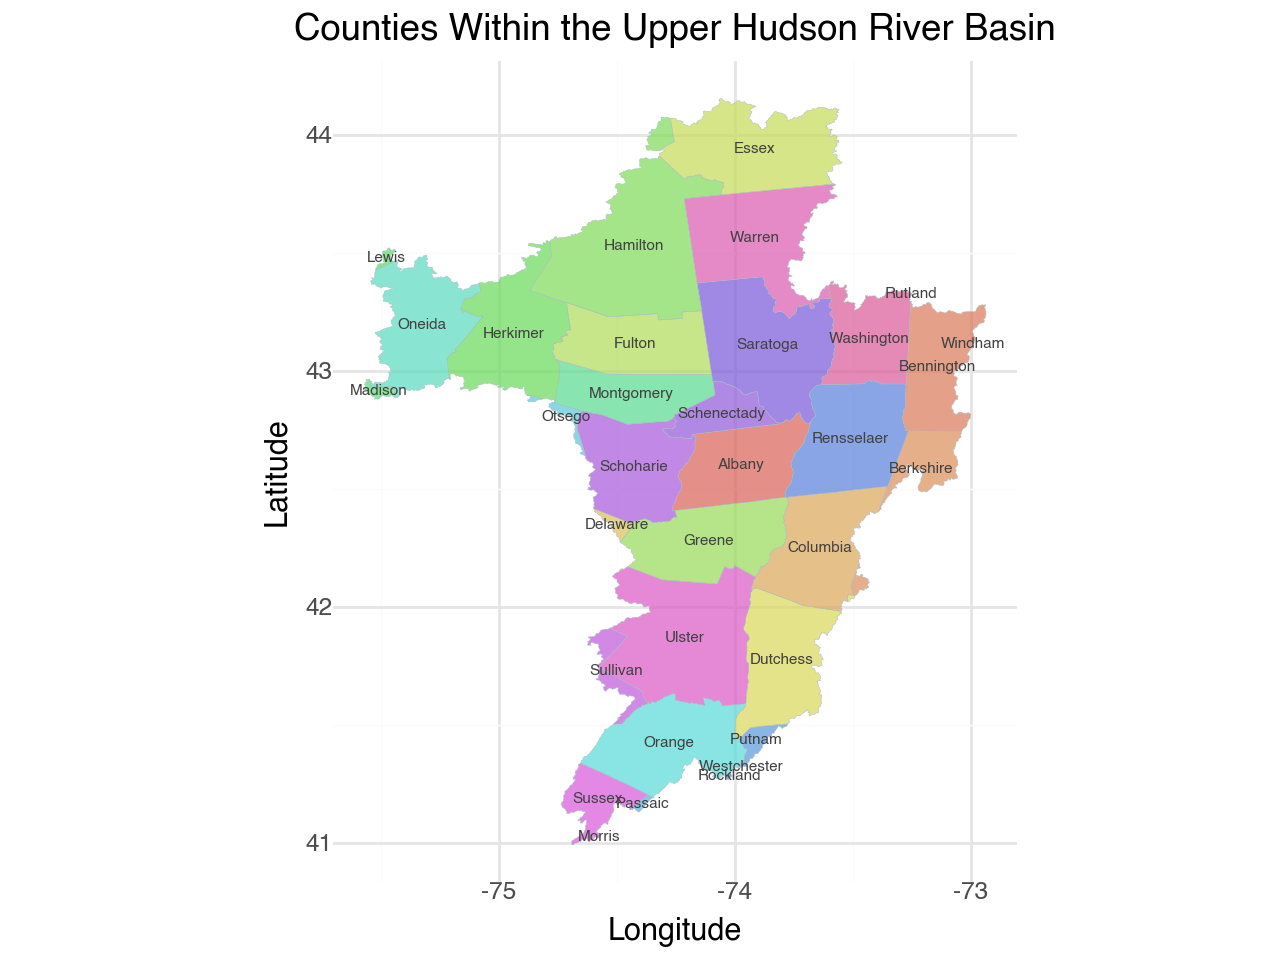

In [83]:
# Define the centroid of each polygon
intersecting_counties_uhb_geom["lon"] = intersecting_counties_uhb_geom.geometry.centroid.x
intersecting_counties_uhb_geom["lat"] = intersecting_counties_uhb_geom.geometry.centroid.y

# Map of the selected states
intersecting_counties_uhb_geom_map = (
    ggplot(intersecting_counties_uhb_geom)
    + geom_map(
        mapping=aes(fill="NAME", geometry="geometry"),
        data=intersecting_counties_uhb_geom,
        inherit_aes=False, 
        color = map_style.get('us_counties').get('color'),
        size=0.1,
        alpha = 0.7
    )
    + geom_text(
        mapping=aes(x="lon", y="lat", label="NAME"),
        size=5.5,
        color=map_style.get('text').get('color')
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="Counties Within the Upper Hudson River Basin", x="Longitude", y="Latitude")
)

intersecting_counties_uhb_geom_map.show()

## 4. Study Region Boundary Box

The boundary box is important for downloading data. Also, a buffer zone of 1, 5 and 10km is considered for selecting precipitation stations, for even though, those precipitation station do not fall within the study region, it may capture the spatial distribution of rain within the study region. 

In [84]:
# Boundary box
minx, miny, maxx, maxy = upper_hudson_basin.bounds.values[0].tolist()

bottom_left = (minx, miny)
bottom_right = (maxx, miny)
top_right = (maxx, maxy)
top_left = (minx, maxy)

bbox = dict(
    bottom_left=bottom_left,
    bottom_right=bottom_right,
    top_right=top_right,
    top_left=top_left,
    CRS=upper_hudson_basin.crs.to_string()
)

# Print as markdown
markdown_output = '  \n'.join([f"**{key}:** {value}" for key, value in bbox.items()])
display(Markdown('#### Boundary Box for Upper Hudson basin:\n' + markdown_output))


#### Boundary Box for Upper Hudson basin:
**bottom_left:** (-75.57203596501256, 40.99063752699914)  
**bottom_right:** (-72.9348661493143, 40.99063752699914)  
**top_right:** (-72.9348661493143, 44.15304728042378)  
**top_left:** (-75.57203596501256, 44.15304728042378)  
**CRS:** EPSG:4269

In [50]:
# Save boundary box locally as JSON file
upper_hudson_basin_bbox_path = project_base_path / 'data' / 'geo' /'json' / 'upper_hudson_basin_bbox.json'

if not os.path.exists(upper_hudson_basin_bbox_path):
    try:
        # Export in JSON format
        with open(upper_hudson_basin_bbox_path, 'w') as f:
            json.dump(bbox, f, indent=4)
        display(Markdown('##### File with boundary box successfully saved locally as JSON.'))
    except Exception as err:
        print(f'Failed to save boundary box as JSON file: {err}')
else:
    print('Boundary box JSON file already exists. Skipping saving process.')

##### File with boundary box successfully saved locally as JSON.

In [86]:
# Save boundary box in ESPG:3857 as GeoJson file, used to download data from MRLC
upper_hudson_basin_bbox_3857_path = project_base_path / 'data' / 'raw'/ 'geo' / 'json' / 'upper_hudson_basin_3857_bbox.geojson'

# Create a polygon from the bounding box coordinates
bbox_polygon = Polygon([
    bbox['bottom_left'], 
    bbox['bottom_right'], 
    bbox['top_right'], 
    bbox['top_left'], 
    bbox['bottom_left']  # Close the polygon
])

# Create a GeoDataFrame with the original CRS from upper_hudson_basin
gdf_bbox = gpd.GeoDataFrame({'geometry': [bbox_polygon]}, crs=upper_hudson_basin.crs)

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
gdf_bbox_3857 = gdf_bbox.to_crs(epsg=3857)

# Save the reprojected bounding box as a GeoJSON file locally
if upper_hudson_basin_bbox_3857_path.exists():
    print('GeoJSON file already exists. Skipping saving process.')
else:
    gdf_bbox_3857.to_file(upper_hudson_basin_bbox_3857_path, driver='GeoJSON')
    print('GeoJSON file saved successfully.')


GeoJSON file already exists. Skipping saving process.


In [40]:
# Export Study Region
try:
    upper_hudson_basin_path = shapefiles_base_path / 'upper_hudson_basin' / 'upper_hudson_basin.shp'
    upper_hudson_basin_path.parent.mkdir(parents=True, exist_ok=True)
    upper_hudson_basin.to_file(upper_hudson_basin_path)
    print('Study region successfully saved as shapefile.')
except Exception as err:
    print(f'Failed to save study region as shapefile: {err}')

Study region successfully saved as shapefile.


In [45]:
# Reproject the to meters unit
projection_crs = "EPSG:26918" #Projection used 18N UTM zone
upper_hudson_basin_50918 = upper_hudson_basin.to_crs(projection_crs)

# Buffers
upper_hudson_basin_1km_buffer = upper_hudson_basin_50918.buffer(1000)
upper_hudson_basin_5km_buffer = upper_hudson_basin_50918.buffer(5000)
upper_hudson_basin_10km_buffer = upper_hudson_basin_50918.buffer(10000)
upper_hudson_basin_30km_buffer = upper_hudson_basin_50918.buffer(30000)

# Define path to export shapefiles
upper_hudson_basin_1km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_1km_buffer' / 'upper_hudson_basin_1km_buffer.shp'
upper_hudson_basin_5km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_5km_buffer' / 'upper_hudson_basin_5km_buffer.shp'
upper_hudson_basin_10km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_10km_buffer' / 'upper_hudson_basin_10km_buffer.shp'
upper_hudson_basin_30km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_30km_buffer' / 'upper_hudson_basin_30km_buffer.shp'


basin_list = [upper_hudson_basin_1km_buffer, upper_hudson_basin_5km_buffer, upper_hudson_basin_10km_buffer, upper_hudson_basin_30km_buffer]
basin_path_list = [upper_hudson_basin_1km_buffer_path, upper_hudson_basin_5km_buffer_path, upper_hudson_basin_10km_buffer_path, upper_hudson_basin_30km_buffer_path]

# Export shape files
try:
    for basin, path in zip(basin_list, basin_path_list):
        print(f'Saving shapefile {os.path.splitext(os.path.basename(path))[0]}...')
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        basin.to_file(path)
    print('All shapefiles exported successfully.')
except Exception as err:
    print(f'Failed to export shapefiles: {err}')



Saving shapefile upper_hudson_basin_1km_buffer...
Saving shapefile upper_hudson_basin_5km_buffer...
Saving shapefile upper_hudson_basin_10km_buffer...
Saving shapefile upper_hudson_basin_30km_buffer...
All shapefiles exported successfully.


## 5. Study Region Map

In [ ]:
merged_geom = pd.concat(
    [
        intersecting_counties_uhb_geom[['geometry']].assign(LAYER= 'counties')
    ]
)
study_map = (
    ggplot()
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=intersecting_counties_uhb_geom,
        inherit_aes=False, 
        color = map_style.get('us_counties').get('color'),
        size=0.3,
        fill = None
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=us_eastern,
        inherit_aes=False, 
        color = map_style.get('us_states').get('color'),
        size=0.5,
        fill = None
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=upper_hudson_basin,
        fill = None,
        inherit_aes=False, 
        color = map_style.get('watershed_boundary').get('color'),
        size = 0.7
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="Study Regdion", x="Longitude", y="Latitude")
)
study_map.show()

ValueError: No objects to concatenate

In [106]:
drainage_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 0 entries
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tnmid       0 non-null      object        
 1   metasource  0 non-null      object        
 2   sourcedata  0 non-null      object        
 3   sourceorig  0 non-null      object        
 4   sourcefeat  0 non-null      object        
 5   loaddate    0 non-null      datetime64[ms]
 6   areasqkm    0 non-null      float64       
 7   agencycode  0 non-null      object        
 8   sitenumber  0 non-null      object        
 9   stationnam  0 non-null      object        
 10  totalareas  0 non-null      float64       
 11  nwistotala  0 non-null      object        
 12  contributi  0 non-null      float64       
 13  nwiscontri  0 non-null      object        
 14  referencet  0 non-null      object        
 15  remarks     0 non-null      object        
 16  shape_Leng  0 non-null      fl